<a href="https://colab.research.google.com/github/tina287/fianceHomework/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9AHW_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 取得股價資料

In [ ]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
import matplotlib.pyplot as plt # 繪圖套件

In [ ]:
# 取得股票資訊，輸入股票代號
stock_id = "2330.tw"
# stock_id = "2357.tw"
# stock_id = "2317.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2023, 1, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位設為資料表索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,306.430176,31754120
2020-01-03,344.0,345.0,335.5,339.5,306.882111,41811268
2020-01-06,333.0,334.5,332.0,332.0,300.102692,45343057
2020-01-07,332.5,333.0,326.5,329.5,297.842896,50879181
2020-01-08,325.0,333.0,325.0,329.5,297.842896,37567748
...,...,...,...,...,...,...
2022-12-26,454.0,457.0,453.5,456.5,441.325226,8793306
2022-12-27,458.0,462.5,457.0,457.0,441.808563,10264001
2022-12-28,451.0,452.0,446.0,451.0,436.008026,32578949


# <b>深度學習預測股價</b>

In [ ]:
import yfinance as yf  # Yahoo Finance 資料擷取套件
import datetime as dt  # 日期與時間處理套件
import pandas as pd  # 資料處理套件
import numpy as np  # 數值計算套件
import matplotlib.pyplot as plt  # 繪圖套件
from tensorflow.keras.models import Sequential  # Keras 神經網路模型構建工具
from tensorflow.keras.layers import Dense  # Keras 全連接層 (Dense layer)
from sklearn.preprocessing import MinMaxScaler  # 特徵縮放器 (Min-Max 標準化)
from sklearn.metrics import mean_squared_error  # 衡量模型誤差 (均方誤差)

In [ ]:
# Step 1: 設置股票代號和時間段
stock_id = "2330.TW"
start = dt.datetime(2020, 1, 1)  # 開始日期
end = dt.datetime(2023, 1, 1)    # 結束日期

# Step 2: 下載股票數據
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 設置日期索引
stock_data.set_index('Date', inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,306.430176,31754120
2020-01-03,344.0,345.0,335.5,339.5,306.882111,41811268
2020-01-06,333.0,334.5,332.0,332.0,300.102692,45343057
2020-01-07,332.5,333.0,326.5,329.5,297.842896,50879181
2020-01-08,325.0,333.0,325.0,329.5,297.842896,37567748
...,...,...,...,...,...,...
2022-12-26,454.0,457.0,453.5,456.5,441.325226,8793306
2022-12-27,458.0,462.5,457.0,457.0,441.808563,10264001
2022-12-28,451.0,452.0,446.0,451.0,436.008026,32578949


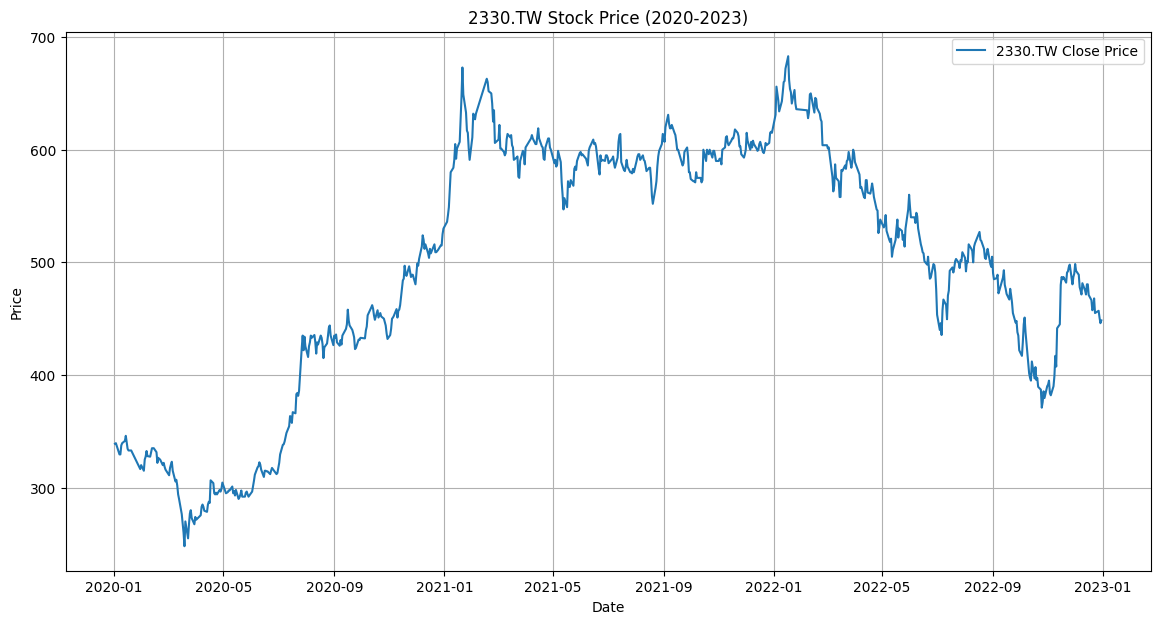

In [ ]:
# Step 3: 可視化股票收盤價
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label="2330.TW Close Price")
plt.title("2330.TW Stock Price (2020-2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 4: 構建訓練和測試數據
train_size = int(len(stock_data) * 0.8)
train_data, test_data = stock_data[['Close']][:train_size], stock_data[['Close']][train_size:]

In [ ]:
# Step 5:
# 創建 MinMaxScaler 實例，設定範圍為 (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# 使用訓練數據來擬合標準化模型，並對訓練和測試數據進行轉換
train_data_scaled = scaler.fit_transform(train_data)  # 擬合並轉換訓練數據
test_data_scaled = scaler.transform(test_data)        # 僅轉換測試數據

In [ ]:
# Step 6: 建立 ANN 模型
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))  # 第一隱藏層
model.add(Dense(32, activation='relu'))               # 第二隱藏層
model.add(Dense(1, activation='linear'))              # 輸出層
model.compile(loss='mse', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 7: 訓練模型
X_train, y_train = train_data_scaled[:-1], train_data_scaled[1:] # 使用今天的股價預測明天的股價
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3004
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0641 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8645e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6135e-04  
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8919e-04  
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6902e-04 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7897e-04 
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7799e-04 
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8559e-04 
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6039e-04 
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6286e-04 
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━

In [ ]:
# Step 8: 預測測試數據
X_test, y_test = test_data_scaled[:-1], test_data_scaled[1:]
predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Step 9: 反轉標準化
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
# Step 10: 使用 RMSE 評估模型
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 10.020264500972281


In [ ]:
train_data

,Close
Date,
2020-01-02,339.0
2020-01-03,339.5
2020-01-06,332.0
2020-01-07,329.5
2020-01-08,329.5
...,...
2022-05-30,547.0
2022-05-31,560.0
2022-06-01,549.0


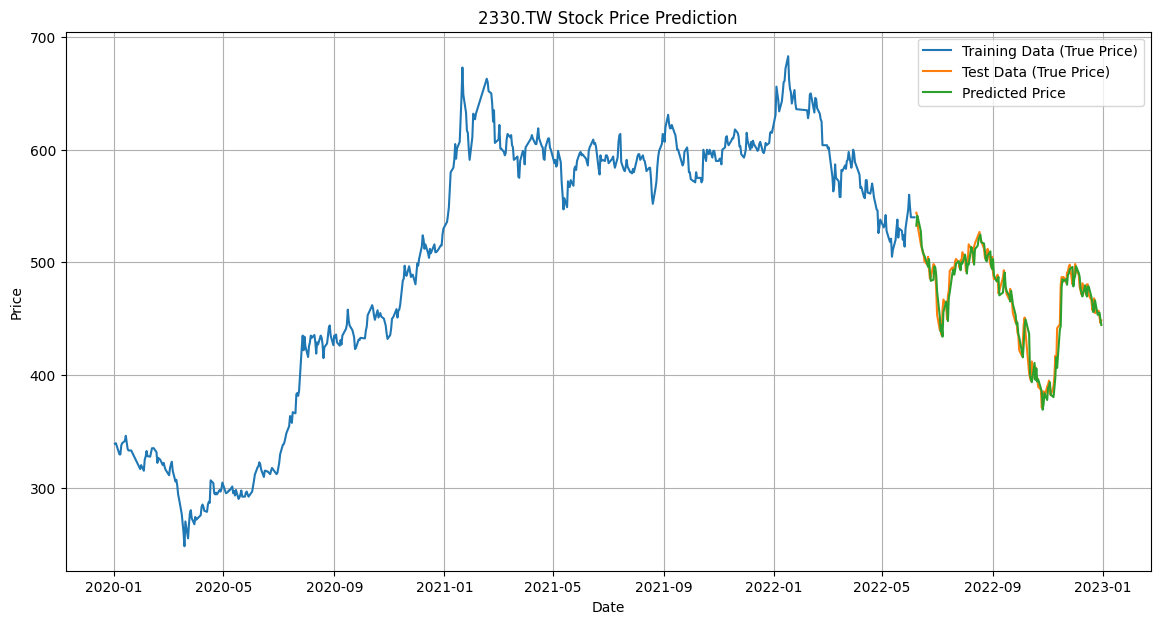

In [ ]:
# 可視化訓練集與測試集
plt.figure(figsize=(14, 7))

# 繪製訓練集的真實價格
plt.plot(stock_data.index[:train_size], train_data, label="Training Data (True Price)")  # 訓練集真實值

# 調整測試資料的索引範圍，確保預測和實際值對齊
adjusted_index = stock_data.index[train_size + 1 : train_size + 1 + len(predictions_rescaled)]

# 繪製測試集的真實價格與預測價格
plt.plot(adjusted_index, y_test_rescaled[:len(predictions_rescaled)], label="Test Data (True Price)")  # 測試集真實值
plt.plot(adjusted_index, predictions_rescaled, label="Predicted Price")  # 預測值

# 繪圖標題與軸標籤
plt.title("2330.TW Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

# 加上圖例與格線
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

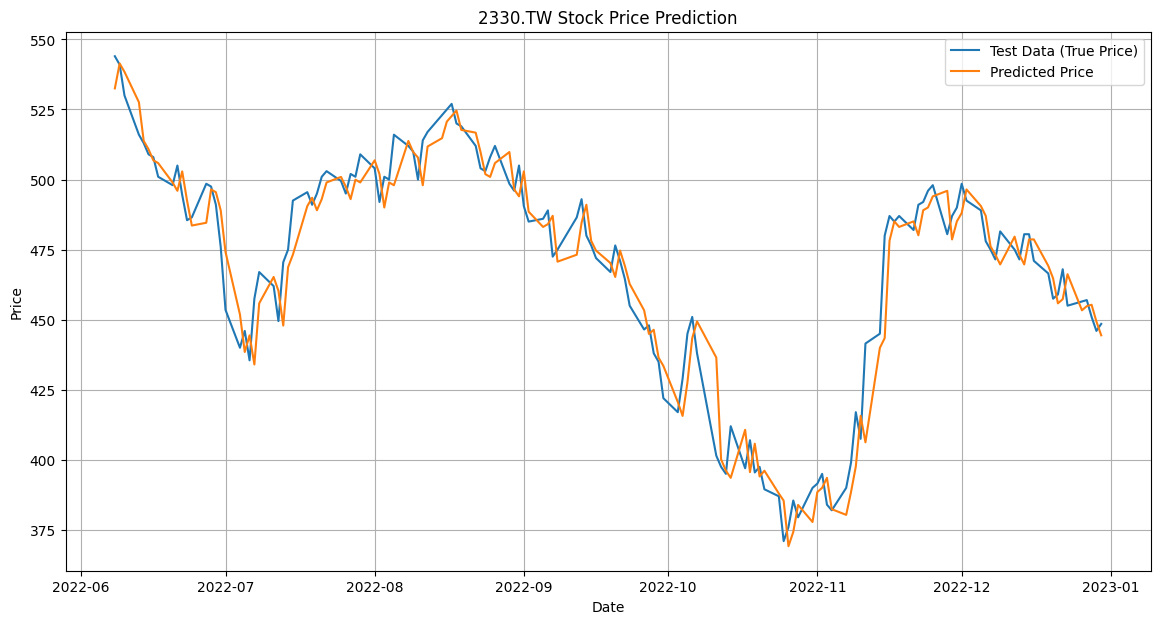

In [ ]:
# 只可視化測試集
plt.figure(figsize=(14, 7))

# 調整測試資料的索引範圍，確保預測和實際值對齊
adjusted_index = stock_data.index[train_size + 1 : train_size + 1 + len(predictions_rescaled)]

# 繪製測試集的真實價格與預測價格
plt.plot(adjusted_index, y_test_rescaled[:len(predictions_rescaled)], label="Test Data (True Price)")  # 測試集真實值
plt.plot(adjusted_index, predictions_rescaled, label="Predicted Price")  # 預測值

# 繪圖標題與軸標籤
plt.title("2330.TW Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

# 加上圖例與格線
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()